# Imports

In [1]:
!pip install chess
!pip install tensorflow

In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import InputLayer
from keras.layers import *
from keras.optimizer_v2.adam import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ast
from IPython.display import clear_output
import sys

import chess.pgn

# Data Preparation

## Functions

In [2]:
import csv
import collections
openings = collections.defaultdict(list)

with open('openings.csv', mode='r') as infile:
    reader = csv.reader(infile)
    headers = next(reader) 
    for rows in reader:
      move = " ".join(ast.literal_eval(rows[3]))
      openings[rows[2]].append(move)

In [3]:
# Si pas de variante trouvée, moyenne des longueurs des variantes

def get_mid_game(game):
  mean = 0
  eco_code = game.headers["ECO"]
  move_sequence = str(game.mainline_moves()).replace(". ", ".")
  for move in openings[eco_code]:
    mean += len(move.split(" "))
    if move in move_sequence:
      return len(move.split(" "))
  if len(openings[eco_code]) > 0:
    return mean//len(openings[eco_code])
  else: 
    return 0

In [4]:
# 4 or less pieces on the board (excluding King and pawns)
def get_end_game(game, theory):
    board = chess.Board()
    count = 0
    pieces = ['r', 'n', 'b', 'q']
    if theory == "minev":
        # For each move
        for move in game.mainline_moves():
            board.push(move)
            pieces_count = 0
            # Coun how many pieces different from pawns and kings
            for p in pieces:
                pieces_count += str(board).count(p)
                pieces_count += str(board).count(p.capitalize())
            # If that number is less or equal to 4 return the number of moves to get to end game
            if pieces_count <= 4:
                return count
            count += 1
    elif theory == "flear":
        for move in game.mainline_moves():
            board.push(move)
            pieces_count_w = 0
            pieces_count_b = 0
            # Coun how many pieces different from pawns and kings
            for p in pieces:
                pieces_count_b += str(board).count(p)
                pieces_count_w += str(board).count(p.capitalize())
            # If that number is less or equal to 4 return the number of moves to get to end game
            if pieces_count_b <= 1 and pieces_count_w <= 1:
                return count
            count += 1
    elif theory == "fine":
        for move in game.mainline_moves():
            board.push(move)
            if (not "q" in str(board)) and (not "Q" in str(board)):
                return count
            count += 1
    return 1000

In [5]:
def get_pawns(board_list):
  black_pawns = []
  white_pawns = []
  # get all positions of pawns
  for i, line in enumerate(board_list):
    for j, tile in enumerate(line):
      if tile == "p":
        black_pawns.append((i,j))
      if tile == "P":
        white_pawns.append((i,j))
  return (black_pawns, white_pawns)


In [6]:
def get_passed_pawns(pawns):
  black_pawns, white_pawns = pawns
  passed_pawns = black_pawns + white_pawns
  for bp in black_pawns:
    for wp in white_pawns:
      if bp[0] < wp[0]:
        if bp[1] - 1 == wp[1] or bp[1] + 1 == wp[1] or bp[1] == wp[1]:
          passed_pawns.remove(bp)
          break

  for wp in white_pawns:
    for bp in black_pawns:
      if wp[0] > bp[0]:
        if bp[1] == wp[1] - 1 or bp[1] == wp[1] + 1 or bp[1] == wp[1]:
          passed_pawns.remove(wp)
          break
  return passed_pawns

In [7]:
def get_isolated_pawns(pawns):
  black_pawns, white_pawns = pawns
  isolated_pawns = black_pawns + white_pawns
  for p in black_pawns:
    for bp in black_pawns:
      if p != bp:
        if p[1] - 1 == bp[1] or p[1] + 1 == bp[1]:
          isolated_pawns.remove(p)
          break
  for p in white_pawns:
    for wp in white_pawns:
      if p != wp:
        if p[1] - 1 == wp[1] or p[1] + 1 == wp[1]:
          isolated_pawns.remove(p)
          break

  return isolated_pawns

In [8]:
def handle_dynamic(game, game_size, end):
  single_game = []
  cost = [1, 3.05, 3.33, 5.63, 9.5, 10, 1, 3.05, 3.33, 5.63, 9.5, 10]
  lex = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
  non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                [0.90, 0.95, 1.05, 1.10, 1.10, 1.05, 0.95, 0.90],
                [0.90, 0.95, 1.05, 1.15, 1.15, 1.05, 0.95, 0.90],
                [0.90, 0.95, 1.10, 1.20, 1.20, 1.10, 0.95, 0.90],
                [0.97, 1.03, 1.17, 1.27, 1.27, 1.17, 1.03, 0.97],
                [1.06, 1.12, 1.25, 1.40, 1.40, 1.25, 1.12, 1.06],
                [1, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1]]
  isolated = [1, 1, 1, 1.05, 1.30, 2.1, 1, 1]
  connected = [1, 1, 1, 1.15, 1.35, 2.1, 1, 1]
  passed = [1, 1, 1, 1.30, 1.55, 2.1, 1, 1]
  passed_connected = [1, 1, 1, 1.55, 2.3, 3.5, 1, 1]

  midgame = get_mid_game(game) + 1
  endgame = get_end_game(game, theory=end)
  board = chess.Board()

  for n, move in enumerate(game.mainline_moves()):

    if n == midgame:
      non_passed = np.ones((8,8))
    elif n == endgame:
      non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                [1.25, 1.10, 1.00, 0.95, 0.95, 1.00, 1.10, 1.25],
                [1.33, 1.17, 1.07, 1.00, 1.00, 1.07, 1.17, 1.33],
                [1.45, 1.29, 1.16, 1.05, 1.05, 1.16, 1.29, 1.45],
                [1, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1]]


    board.push(move)
    board_list = str(board).replace(" ","").split("\n")
    pawns = get_pawns(board_list)
    # gives a list of passed pawns
    passed_pawns = get_passed_pawns(pawns)
    # gives a list of isolated pawns
    isolated_pawns = get_isolated_pawns(pawns)
    # gives a list of connected pawns
    connected_pawns = connected_pawns = [x for x in pawns[0] + pawns[1] if x not in isolated_pawns]
    vec = [np.zeros((8,8)) for i in range(12)]
    for line_pos in range(8) :
      for col_pos in range(8) :
        piece = board_list[line_pos][col_pos]
        if piece in lex :
          lex_pos = lex.index(piece)
          value = cost[lex_pos]
          multiplier = 1

          # If pawn is white, rank is inverted
          if piece == "p":
            rank = line_pos
          elif piece == "P":
            rank = -(line_pos + 1)

          if piece == "p" or piece == "P":
            if (line_pos, col_pos) not in passed_pawns:
              value = non_passed[rank][col_pos]
            if (line_pos, col_pos) in passed_pawns and (line_pos, col_pos) in connected_pawns:
              multiplier *= passed_connected[rank]
            elif (line_pos, col_pos) in passed_pawns:
              multiplier *= passed[rank]
            elif (line_pos, col_pos) in connected_pawns:
              multiplier *= connected[rank]
            if (line_pos, col_pos) in isolated_pawns:
              multiplier *= isolated[rank]

          # Assign a value according to the piece position and a multiplier
          vec[lex_pos][line_pos][col_pos] = value * multiplier
    single_game.append(np.asarray(vec))
    if n == game_size - 1: 
      break
  
  if n < game_size - 1:
    for i in range(game_size - n - 1) :
        single_game.append([np.zeros((8,8)) for i in range(12)])
  return np.asarray(single_game)

In [9]:
def handle_dynamic_speelman(game, game_size):
  single_game = []
  cost = [1, 3.05, 3.33, 5.63, 9.5, 10, 1, 3.05, 3.33, 5.63, 9.5, 10]
  lex = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
  non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                [0.90, 0.95, 1.05, 1.10, 1.10, 1.05, 0.95, 0.90],
                [0.90, 0.95, 1.05, 1.15, 1.15, 1.05, 0.95, 0.90],
                [0.90, 0.95, 1.10, 1.20, 1.20, 1.10, 0.95, 0.90],
                [0.97, 1.03, 1.17, 1.27, 1.27, 1.17, 1.03, 0.97],
                [1.06, 1.12, 1.25, 1.40, 1.40, 1.25, 1.12, 1.06],
                [1, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1]]
  isolated = [1, 1, 1, 1.05, 1.30, 2.1, 1, 1]
  connected = [1, 1, 1, 1.15, 1.35, 2.1, 1, 1]
  passed = [1, 1, 1, 1.30, 1.55, 2.1, 1, 1]
  passed_connected = [1, 1, 1, 1.55, 2.3, 3.5, 1, 1]

  midgame = get_mid_game(game) + 1
#   endgame = get_end_game(game, theory=end)
  endgame = False
  board = chess.Board()

  for n, move in enumerate(game.mainline_moves()):

    if n == midgame:
      non_passed = np.ones((8,8))
    if endgame:
      non_passed = [[1, 1, 1, 1, 1, 1, 1, 1],
                [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                [1.20, 1.05, 0.95, 0.90, 0.90, 0.95, 1.05, 1.20],
                [1.25, 1.10, 1.00, 0.95, 0.95, 1.00, 1.10, 1.25],
                [1.33, 1.17, 1.07, 1.00, 1.00, 1.07, 1.17, 1.33],
                [1.45, 1.29, 1.16, 1.05, 1.05, 1.16, 1.29, 1.45],
                [1, 1, 1, 1, 1, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1]]


    board.push(move)
    board_list = str(board).replace(" ","").split("\n")
    pawns = get_pawns(board_list)
    # gives a list of passed pawns
    passed_pawns = get_passed_pawns(pawns)
    # gives a list of isolated pawns
    isolated_pawns = get_isolated_pawns(pawns)
    # gives a list of connected pawns
    connected_pawns = connected_pawns = [x for x in pawns[0] + pawns[1] if x not in isolated_pawns]
    vec = [np.zeros((8,8)) for i in range(12)]
    for line_pos in range(8) :
      for col_pos in range(8) :
        piece = board_list[line_pos][col_pos]
        if piece in lex :
          lex_pos = lex.index(piece)
          value = cost[lex_pos]
          multiplier = 1

          # If pawn is white, rank is inverted
          if piece == "p":
            rank = line_pos
          elif piece == "P":
            rank = -(line_pos + 1)

          if piece == "p" or piece == "P":
            if (line_pos, col_pos) not in passed_pawns:
              value = non_passed[rank][col_pos]
            if (line_pos, col_pos) in passed_pawns and (line_pos, col_pos) in connected_pawns:
              multiplier *= passed_connected[rank]
            elif (line_pos, col_pos) in passed_pawns:
              multiplier *= passed[rank]
            elif (line_pos, col_pos) in connected_pawns:
              multiplier *= connected[rank]
            if (line_pos, col_pos) in isolated_pawns:
              multiplier *= isolated[rank]

          # Assign a value according to the piece position and a multiplier
          vec[lex_pos][line_pos][col_pos] = value * multiplier
          vec = np.asarray(vec)
    single_game.append(vec)
    
    if (vec[:5].sum() <= 13) and (vec[6:11].sum() < 13):
#       print("Endgame detected : ", vec[:5].sum(), vec[6:11].sum(), n)
      endgame = True
    
    if n == game_size - 1: 
      break
  
  if n < game_size - 1:
    for i in range(game_size - n - 1) :
        single_game.append([np.zeros((8,8)) for i in range(12)])
  return np.asarray(single_game)

## Convert PGN to bitmap/algebraic/alphazero/dynamic representation

In [10]:
""" Allows to convert a PGN file into bitmap/algebraic/alphazero/dynamic representation """
def convert_pgn(PGN_FILE, data_type = "bitmap", game_size = 80, max_amount=100, start_at=0, endgame="minev") :
    data=[]
    target=[]
    lex = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
    if data_type == "algebraic" :
        cost = [1, 3, 3, 5, 9, 10, 1, 3, 3, 5, 9, 10]
    elif data_type == "bitmap" :
        cost = [1 for i in range(12)]
    elif data_type == "alphazero" :
        cost = [1, 3.05, 3.33, 5.63, 9.5, 10, 1, 3.05, 3.33, 5.63, 9.5, 10]
    amount = 0
    with open(PGN_FILE) as f:
        game = 0
        #Parse each game
        while True:
            game = chess.pgn.read_game(f)
            if amount >= start_at:
                clear_output(wait=True)
                print(amount, flush=True)
                move_count = 0
                #Avoid the last element
                if game is None :
                  break 

                #Get the result of the game
                score = game.headers["Result"]
                if score.startswith("1-0"):
                    target.append(0)
                elif score.startswith("0-1"):
                    target.append(1)
                else:
                    target.append(2)

                # DYNAMIC DATATYPE PART
                if data_type == "dynamic" :
                    data.append(handle_dynamic(game, game_size=game_size, end=endgame))
#                     data.append(handle_dynamic_speelman(game, game_size=game_size))
                else :
                    #Actual game
                    single_game = []
                    board = chess.Board()

                    #Parse each move
                    for move in game.mainline_moves() :
                        move_count+=1
                        vec = [np.zeros((8,8)) for i in range(12)]
                        board.push(move)
                        board_list = str(board).replace(" ","").split("\n")
                        for line_pos in range(8) :
                            for col_pos in range(8) :
                                if board_list[line_pos][col_pos] in lex :
                                    lex_pos = lex.index(board_list[line_pos][col_pos])
                                    vec[lex_pos][line_pos][col_pos] = cost[lex_pos]
                        single_game.append(np.asarray(vec))
                        #Not exceed game size
                        if move_count == game_size :
                            break
                    #If it doesn't reach the game size, fill with 0
                    if move_count < game_size :
                        for i in range(game_size-move_count) :
                            single_game.append([np.zeros((8,8)) for i in range(12)])

                    single_game = np.asarray(single_game)
                    data.append(single_game)
                    
            amount += 1
            if amount == max_amount + start_at:
                break

        # Reshape datas to fit the model
        data = [[y.reshape(768,) for y in x] for x in data]
        # Normalisation
        data = np.asarray(data)
        # Count White wins, Black wins and Draws
        target = np.array(target, dtype=int)
        unique, counts = np.unique(target, return_counts=True)
        amount = amount - start_at
        print(f"{amount} games converted to {data_type}.")
        print(f"{round(counts[0]/amount*100, 2)}% White wins, {round(counts[1]/amount*100, 2)}% Black wins, {round(counts[2]/amount*100, 2)}% Draws.")
        # Convert game results to categorical data
        target = keras.utils.to_categorical(target, num_classes=3)
        
    return (data, target)

# Dataset

In [11]:
SEQ_LENGTH = 80

In [12]:
dataset, target = convert_pgn("KingBase2018-B20-B49.pgn", max_amount=30000, data_type="bitmap", game_size=SEQ_LENGTH)

29999
30000 games converted to bitmap.
36.06% White wins, 31.46% Black wins, 32.48% Draws.


In [16]:
# Optimization:
# https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4

# TODO : Normalize and (maybe) Standardize data
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# Only works in 2 dim
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
dataset.shape

(30000, 80, 768)

In [18]:
x_train, x_rem, y_train, y_rem = train_test_split(dataset, target, train_size = 0.6, random_state = 4) # random_state = 4 for reproductible results

In [20]:
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, random_state = 4)

In [23]:
print(x_train.shape, x_val.shape, x_test.shape)

(18000, 80, 768) (6000, 80, 768) (6000, 80, 768)


In [24]:
ytrain = np.asarray([np.argmax(x) for x in y_train])
unique, counts = np.unique(ytrain, return_counts=True)
print(unique, counts)

[0 1 2] [6518 5647 5835]


In [25]:
ytest = np.asarray([np.argmax(x) for x in y_test])
unique, counts = np.unique(ytest, return_counts=True)
print(unique, counts)

[0 1 2] [2151 1894 1955]


In [26]:
yval = np.asarray([np.argmax(x) for x in y_val])
unique, counts = np.unique(yval, return_counts=True)
print(unique, counts)

[0 1 2] [2148 1897 1955]


# Content Model

In [31]:
model = Sequential()
model.add(InputLayer(input_shape=(SEQ_LENGTH, 768)))
model.add(LSTM(512, activation="tanh", dropout=0.2, return_sequences=True))
model.add(LSTM(256, activation="tanh", dropout=0.2, return_sequences=True))
model.add(LSTM(128, activation="tanh", dropout=0.2, return_sequences=False))
model.add(Dense(32, activation="relu"))
# Changement ici
model.add(Dense(3, activation='softmax'))

# 0.000001
adam = Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.99, amsgrad=False)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 80, 512)           2623488   
                                                                 
 lstm_10 (LSTM)              (None, 80, 256)           787456    
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3,612,291
Trainable params: 3,612,291
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train, y_train, epochs=80, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/80
563/563 [==============================] - 538s 949ms/step - loss: 1.0965 - accuracy: 0.3829 - val_loss: 1.0940 - val_accuracy: 0.3940
Epoch 2/80
563/563 [==============================] - 539s 958ms/step - loss: 1.0926 - accuracy: 0.4087 - val_loss: 1.0911 - val_accuracy: 0.4095
Epoch 3/80
563/563 [==============================] - 546s 971ms/step - loss: 1.0891 - accuracy: 0.4167 - val_loss: 1.0886 - val_accuracy: 0.4192
Epoch 4/80
563/563 [==============================] - 550s 978ms/step - loss: 1.0859 - accuracy: 0.4297 - val_loss: 1.0862 - val_accuracy: 0.4263
Epoch 5/80
563/563 [==============================] - 551s 979ms/step - loss: 1.0830 - accuracy: 0.4361 - val_loss: 1.0839 - val_accuracy: 0.4287
Epoch 6/80
563/563 [==============================] - 554s 984ms/step - loss: 1.0802 - accuracy: 0.4423 - val_loss: 1.0817 - val_accuracy: 0.4320
Epoch 7/80
563/563 [==============================] - 551s 979ms/step - loss: 1.0774 - accuracy: 0.4430 - val_loss: 1.0797 -

# Results

In [33]:
score = model.evaluate(x_test, y_test)

188/188 [==============================] - 59s 316ms/step - loss: 1.0129 - accuracy: 0.5173


In [34]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.0129059553146362, 0.5173333287239075]


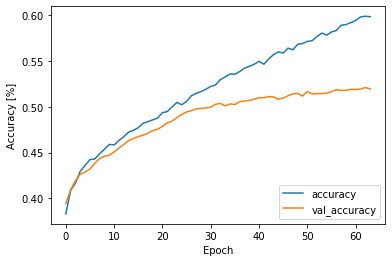

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.legend(["accuracy", "val_accuracy"], loc ="lower right") 

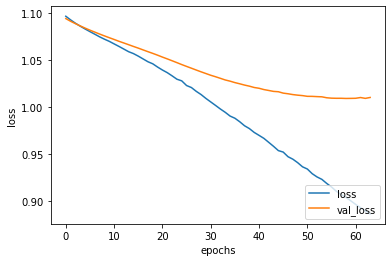

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss", "val_loss"], loc ="lower right") 